In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
import re , os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplot

In [2]:
import shutil
try :
    os.makedirs("./NNEnsembleResult/adaboost_a")
    os.makedirs("./NNEnsembleResult/adaboost_b")
except Exception as e :
    shutil.rmtree("./NNEnsembleResult/adaboost_a")
    shutil.rmtree("./NNEnsembleResult/adaboost_b")
    os.makedirs("./NNEnsembleResult/adaboost_a")
    os.makedirs("./NNEnsembleResult/adaboost_b")

In [3]:
from tensorflow.contrib.layers import *

def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [4]:
data = pd.read_csv("./../Data/income_evaluation.csv")
objcol = data.select_dtypes("object").columns.tolist()
data[objcol] = data[objcol].astype("category")
data.columns = [i.strip() for i in data.columns.tolist()]

In [5]:
data["income"].head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: income, dtype: category
Categories (2, object): [<=50K, >50K]

In [6]:
data["income"].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

In [7]:
data["income"] = data["income"].cat.codes
target = data.pop("income")
num_col = data.select_dtypes("int").columns.tolist()

In [8]:
cat_col = data.select_dtypes("category").columns.tolist()

In [9]:
onehot_data = pd.get_dummies(data , columns= cat_col)

In [10]:
# Trval_X , Test_X , Trval_y , Test_y = train_test_split(onehot_data , target , test_size = 0.3)
# Trval_X.reset_index(drop=True , inplace=True)
# Trval_y.reset_index(drop=True , inplace=True)
Train_X , Test_X , Train_y , Test_y = train_test_split(onehot_data , 
                                                         target , test_size = 0.3)
#tr_idx = np.array(Train_X.index.tolist())
#va_idx = np.array(Valid_X.index.tolist())

In [11]:
one_hot_var = Train_X.columns.tolist()
in_var = data.columns.tolist()

In [12]:
def OneHotIndex(in_var , num_var , one_hot_var) :
    start_idx = 0
    key_store = {}
    store = []
    for idx , col in enumerate(in_var) :
        if col in num_var :
            aa = [start_idx , start_idx +1]
            store.append(aa)
            start_idx += 1
        else :
            find = [idx for idx , ck in enumerate(one_hot_var) if re.search("^{}_".format(col) , ck)]
            nn = len(find)
            aa = [start_idx , start_idx + nn]
            start_idx += nn
            store.append(aa)
        key_store[col] = aa
    return key_store , store

In [13]:
key_onehot_store , onehot_store = OneHotIndex(in_var , num_col , one_hot_var)

In [14]:
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [15]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


numeric_features = num_col 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),])

In [17]:
clf.fit(Train_X)
Train_X[num_col] = clf.transform(Train_X)
#Valid_X[num_col] = clf.transform(Valid_X)
Test_X[num_col] = clf.transform(Test_X)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

## 앙상블 테스트

In [18]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values

In [19]:
def tf_mish(x, name="mish") :
    act = x * tf.nn.tanh(tf.nn.softplus(x))
    act = tf.identity(act , name)
    return act

In [20]:
row , dim = Train_X_np.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim] , name="X")
y = tf.placeholder(tf.float32, shape = [ None , 1] , name="y")
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")

22792 108


In [21]:
print(in_var)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [22]:
def variable_select(in_var = None , method = None , select_n = None , NTree = None) :
    var_n = len(in_var)
    if method== "sqrt" :
        value =np.sqrt(var_n)
    elif method == "log2" :
        value =np.log2(var_n)
    elif method == "select" :
        value = select_n
    else :
        value = var_n
    return [list(np.random.choice(in_var ,
                                  replace = False , 
                                  size = value)) for _ in range(NTree)]
select_var = variable_select(in_var=in_var , method="select" , 
                               select_n= 10 , NTree= 5)

In [23]:
print(select_var)

[['hours-per-week', 'fnlwgt', 'marital-status', 'relationship', 'education-num', 'education', 'native-country', 'race', 'occupation', 'capital-gain'], ['fnlwgt', 'marital-status', 'capital-gain', 'age', 'workclass', 'capital-loss', 'race', 'sex', 'occupation', 'hours-per-week'], ['race', 'sex', 'age', 'fnlwgt', 'workclass', 'occupation', 'capital-gain', 'relationship', 'marital-status', 'education'], ['relationship', 'sex', 'capital-loss', 'education', 'occupation', 'native-country', 'hours-per-week', 'marital-status', 'education-num', 'fnlwgt'], ['age', 'occupation', 'capital-loss', 'relationship', 'capital-gain', 'education', 'fnlwgt', 'workclass', 'marital-status', 'native-country']]


In [24]:
# var = select_var[0]
# x_input = []
# for key in var :
#     start_node , terminal_node = key_onehot_store[key]
#     diff = terminal_node - start_node
#     X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
#     x_input.append(X_Split)

In [25]:
def Classifier_V2(X , hidden = [[],[]], Nensemble = select_var ) :
    Ensembles = []
    with tf.variable_scope("Ensembles"):
        for idx , __vars__ in enumerate(Nensemble) :
            x_input = []
            for key in __vars__ :
                start_node , terminal_node = key_onehot_store[key]
                diff = terminal_node - start_node
                X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
                x_input.append(X_Split)
            x_input = tf.concat(x_input , axis = 1)
            TOTAL_DIM = x_input.get_shape().as_list()[1]
            SELECT = np.random.randint(0 , len(activate_candidate) , 1)[0]
            SELECT2 = np.random.randint(0 , len(init_candidate) , 1)[0]
            activation = activate_candidate[SELECT]
            init = init_candidate[SELECT2]
            dims = hidden[idx]
            dims = [TOTAL_DIM] + dims
            print(dims)
            for idx2 , h_dim in enumerate(dims) :
                if idx2 == 0 :
                    Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                                                name="W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = tf.matmul( x_input , Weight) + Bias
                    Layer = activation(Layer)
                    Weight =get_weight_variable(shape = [TOTAL_DIM , 10], 
                                                name="Info_W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    InfoLayer = tf.matmul( x_input , Weight)
                    Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                else :
                    if idx2 == 1 : h_n = dims[idx2-1] + 10
                    else : h_n = dims[idx2-1]
                    Weight =get_weight_variable(shape = [h_n ,h_dim ], 
                                                name="W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    if idx2 == 1 : Layer = tf.concat([Layer, InfoLayer], axis = 1)
                    else : pass
                    Layer = tf.matmul( Layer , Weight) + Bias
                    if len(dims) == idx2+1 : 
                        pass
                    else : 
                        Layer = activation(Layer)
                        Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
            Ensembles.append(Layer)
        return Ensembles

In [26]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))
activate_candidate = \
[tf.nn.selu, tf_mish , tf.nn.leaky_relu , tf.nn.elu ]
init_candidate = ["xavier_uniform","xavier_normal", "he_normal", "he_uniform","caffe_uniform"]

In [27]:
HIDDEN = [
    [ 50 , 50,  target_n] , 
    [ 80 , 50, target_n] ,
    [ 60 , 50, target_n] ,
    [ 70 , 50, target_n] ,
    [ 40 , 20, target_n]
         ]
NModels = Classifier_V2(X , hidden = HIDDEN , Nensemble= select_var )

W0118 21:55:19.604668 139721959667456 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



[95, 50, 50, 2]
[43, 80, 50, 2]
[63, 60, 50, 2]
[92, 70, 50, 2]
[99, 40, 20, 2]


In [28]:
NModels_MEAN = tf.reduce_mean(NModels , axis = 0)
Probs = tf.nn.softmax(NModels_MEAN)
y_one_hot = tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2)

In [29]:
weights = tf.placeholder(tf.float32 , [None , 5], name ="adaboost_weight")
alpha_value = tf.placeholder(tf.float32 , [5,1,1] , name ="alpha")

In [30]:
# YPred = tf.one_hot(tf.argmax(Probs,axis=1) ,depth=2)
# #Equals = tf.equal(YPred , y_one_hot)
# Equals = tf.cast(tf.equal(tf.argmax(YPred, axis = 1) , tf.argmax(y_one_hot, axis = 1)),
#                  dtype = tf.float32)
# w = weights * tf.reshape(Equals,(-1,1))
# err = tf.reduce_sum(w) / tf.reduce_sum(weights)
# alpha = tf.log((1-err)/err) 
# w_ = tf.exp(alpha * tf.reshape(Equals,(-1,1)))
# new_w = weights * w_
#newProbs=tf.nn.softmax(tf.reduce_sum(alpha * NModels, axis = 0))
#newTestProbs=tf.nn.softmax(tf.reduce_sum(alpha_value * NModels, axis = 0))


In [31]:
WEIGHT = []
newProbs = []
new_w = []
for idx , model in enumerate(NModels) :
    mProbs = tf.nn.softmax(model)
    mPred = tf.one_hot(tf.argmax(mProbs,axis=1) ,depth=2)
    #Equals = tf.equal(YPred , y_one_hot)
    Equals = tf.cast(tf.equal(tf.argmax(mPred, axis = 1) , tf.argmax(y_one_hot, axis = 1)),
                     dtype = tf.float32)
    w_ = tf.slice(weights , [0, idx] , [-1 , 1])
    w = w_ * tf.reshape(Equals,(-1,1))
    err = tf.reduce_sum(w) / tf.reduce_sum(weights)
    alpha = tf.log((1-err)/err) 
    w_2 = tf.exp(alpha * tf.reshape(Equals,(-1,1)))
    new_w.append(w_ * w_2)
    WEIGHT.append(alpha)
    newProbs.append(alpha * model)
#######
new_w = tf.concat(new_w, axis = 1)
newProbs=tf.nn.softmax(tf.reduce_sum(newProbs, axis = 0))    
WEIGHT_Tensor = tf.convert_to_tensor(WEIGHT)
WEIGHT_Tensor = tf.reshape(WEIGHT_Tensor, (len(NModels),1,1))
newProbs =tf.nn.softmax(
    tf.reduce_sum(
        tf.multiply(WEIGHT_Tensor,
                    tf.convert_to_tensor(NModels))
        , axis = 0))    

newTestProbs=tf.nn.softmax(
    tf.reduce_sum(
        tf.multiply(
            tf.reshape(alpha_value, (len(NModels),1,1)) ,
            tf.convert_to_tensor(NModels)), axis = 0))

# #WEIGHT_Tensor
# A = tf.convert_to_tensor(NModels)

In [32]:
# np.array([100 , 20.,1,1.,30.]).reshape(5,1,1) * A2[:,0:3,:]

In [33]:
# tf.InteractiveSession()
# #tf.one_hot(y , depth= 2).shape
# y = Train_y.values.reshape(-1,1)[0:10].tolist()
# tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2).eval()

In [34]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(Train_y),
                     y= np.squeeze(Train_y))
weight = tf.constant([ y_weight_info[1] ] ) # 

## Version1 (Averaging)

In [35]:
# WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
#                                                logits = NModels_MEAN , 
#                                                pos_weight =  weight)
# Loss = tf.reduce_mean(WCE)

In [36]:
mod = sys.modules[__name__]
for idx , Model in enumerate(NModels) :
    setattr(mod, 'model_{}_softmax'.format(idx), 
            tf.argmax( tf.nn.softmax(Model) , axis = 1 ))

## Version2 (개별)

In [37]:
mod = sys.modules[__name__]
Loss = []
# Probs = 0
for idx , Model in enumerate(NModels) :
    loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                                     logits = Model , 
                                                     pos_weight = weight)
#     Probs +=tf.nn.softmax(Model)
    Loss.append(loss)
    #Loss += loss
Loss = tf.reduce_mean(Loss)
#Loss /= len(NModels)
# Probs = tf.nn.softmax(Probs)

W0118 21:55:20.575368 139721959667456 deprecation.py:506] From <ipython-input-37-71b281ad19c5>:7: calling weighted_cross_entropy_with_logits (from tensorflow.python.ops.nn_impl) with targets is deprecated and will be removed in a future version.
Instructions for updating:
targets is deprecated, use labels instead


## L1 L2 Penalty

In [38]:
vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Ensembles")
L2 = []
WEIGHTS = []
import re 
for v in vars :
    if re.search('W_' , v.name) :
        WEIGHTS.append(v)
        L2.append(tf.nn.l2_loss(v))
Loss += tf.add_n(L2)  * 0.0001
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, WEIGHTS )
Loss += regularization_penalty  * 0.0001

In [39]:
solver = RAdamOptimizer(learning_rate= 1e-4).minimize(Loss ,var_list = vars )

In [40]:
print(Train_X.shape )
print(Train_y.value_counts())
weight_np = np.ones((len(Train_y), 1)) * (1/len(Train_y))
#weight_np

(22792, 108)
0    17292
1     5500
Name: income, dtype: int64


[[15675  1617]
 [ 1841  3659]]
Epoch : 2200 , Loss :0.57615, AUC : 90.27
target 1 oversample n :  1841
[[[1.3862928]]

 [[1.3864281]]

 [[1.3862437]]

 [[1.3863583]]

 [[1.3861492]]]
(22792, 5)


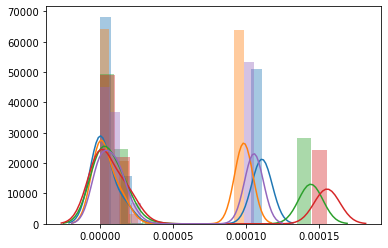

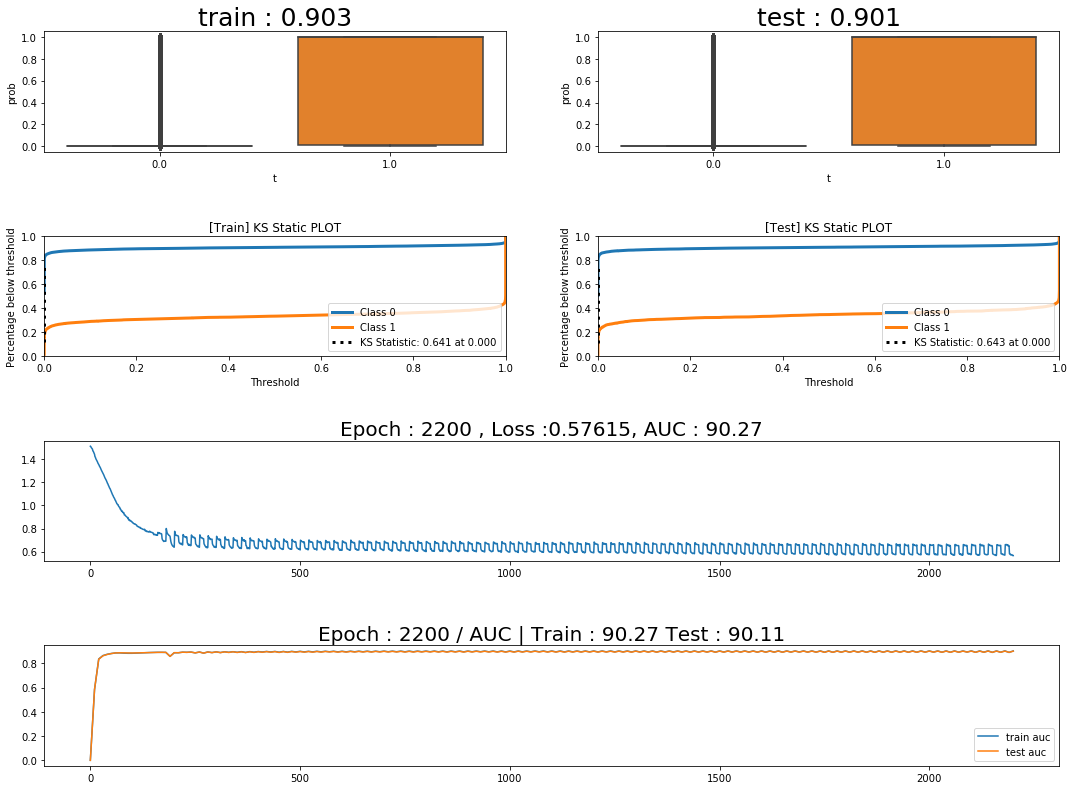

In [ ]:
from sklearn.metrics import confusion_matrix
Epoch = 10000
mb_size = 1000
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
_Loss_ = []
_Epoch_ = []
_Epoch2_ = [0]
_trAUC_ , _teAUC_ = [0] , [0]
weight_np = np.ones((len(Train_y), 5)) * (1/len(Train_y))
print("Train")
for epoch in range(Epoch) :
    print(epoch , end = "\r")
    target1 = np.random.choice(target_1_list ,
                               int(len(target_1_list)/2) ,
                               replace = False )
    target0 = np.random.choice(target_0_list , 
                               len(target_0_list) ,
                               replace = True )
    target1 = list(target1)
    target0 = list(target0)
    if epoch > 10 :
        target1 = target1 + 2 * checkpoint 
    XX = Train_X_np[target1 + target0  , : ]
    YY = Train_y.values[target1 + target0]
    WW_ = weight_np[target1 + target0, :]
    idx = np.random.permutation(len(XX))
    XX = XX[idx , : ]
    YY = YY[idx]
    WW = WW_[idx, :]
    batch_iter = int(len(XX) / mb_size)
    batchLoss = 0
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb.reshape(-1,1) , 
                weights : WW , 
                DropoutRate : 0.5 ,
                training : True 
               }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        batchLoss += LOSS
    batchLoss /= batch_iter
    _Loss_.append(batchLoss)
    _Epoch_.append(epoch)
    
    if epoch % 10 == 0 :
        Feed = {X : Train_X_np  ,
                y : Train_y.values.reshape(-1,1) , 
                DropoutRate : 1.0 ,
                weights : weight_np , 
                training : True 
               }
        probs , weight_np , alpha_result = sess.run([newProbs, new_w , WEIGHT_Tensor ] , feed_dict= Feed)
        weight_np /= np.sum(weight_np , axis = 0)
        real_target = np.squeeze(Train_y.values)
        pred_target = np.argmax(probs,axis =1)
        AUC = roc_auc_score(real_target , probs[:,1])
        DD = pd.DataFrame([real_target ,pred_target], index = ["t","p"]).T
        DD2 = DD[(DD.t == 1) & (DD.p==0)]
        checkpoint = DD2.index.tolist()
    
    msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,LOSS ,AUC*100)
    if (epoch % 50 == 0) & ( epoch > 0 ) :
#         __idx__ = np.random.permutation(len(Train_X_np))
#         __idx__ = np.random.choice(__idx__ , replace = False, size= 500)
#         Feed = { X : Train_X_np[__idx__,:]  ,
#                 DropoutRate : 1 ,
#                 training : True }
        dd = [sess.run( getattr(mod,  "model_{}_softmax".format(i)) , 
                       feed_dict= Feed)  for i in np.arange(len(NModels))]
        s = pd.DataFrame(dd)
        models = np.arange(s.shape[0])
        indexs = np.arange(s.shape[1])
        fig, ax = plt.subplots( figsize = (12,8))
        plt.pcolor(s)
        plt.yticks(np.arange(0.5, len(models), 1),models)
        plt.title(msg)
        plt.savefig(f"./NNEnsembleResult/adaboost_b/plot.{epoch:04d}.png")
        plt.close()    
        #d = pd.DataFrame(dd).sum(axis = 0)
        #plt.scatter( np.arange(len(d)) , d.values)
    if (epoch % 10 == 0) & ( epoch > 0 ):
        clear_output()
        print(confusion_matrix(real_target , pred_target))
        print(msg)
        print("target 1 oversample n : ", len(checkpoint))
        print(alpha_result)
        print(weight_np.shape)
        import seaborn as sns
        for i in np.arange(len(NModels)) :
            sns.distplot(weight_np[:,i])
        plt.show()
        trainDD = pd.DataFrame([real_target ,probs[:,1]],
                               index = ["t","prob"]).T
        trainAUC = AUC
        Feed = {X : Test_X_np  ,
                alpha_value : alpha_result,
                DropoutRate : 1.0 ,
                training : True ,
           }
        testprobs  = sess.run(newTestProbs , feed_dict= Feed)
        real_target = np.squeeze(Test_y.values)
        pred_target = np.argmax(testprobs,axis =1)
        testAUC = roc_auc_score(real_target , testprobs[:,1])
        testDD = pd.DataFrame([real_target ,testprobs[:,1]],
                          index = ["t","prob"]).T
        ###################################################
        fig , axes = plt.subplots(nrows=4 ,ncols=2,
                  figsize=(15,12) )
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.5)
        ax = axes.flatten()
        sns.boxplot(x="t", y="prob", data=trainDD, ax = ax[0])
        ax[0].set_title("train : {:.3f}".format(trainAUC), fontsize= 25)
        sns.boxplot(x="t", y="prob", data=testDD, ax = ax[1])
        ax[1].set_title("test : {:.3f}".format(testAUC), fontsize= 25)
        skplt.metrics.plot_ks_statistic(Train_y.values, probs , 
                                        ax = ax[2] , 
                                        title = "[Train] KS Static PLOT")
        skplt.metrics.plot_ks_statistic(Test_y.values, testprobs ,
                                        ax = ax[3], 
                                        title = "[Test] KS Static PLOT")

        ax3 = plt.subplot(413)
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.7)
        ax3.plot(_Epoch_ , _Loss_ )
        ax3.set_title(msg, fontsize= 20)
        _Epoch2_.append(epoch)
        _trAUC_.append(trainAUC)
        _teAUC_.append(testAUC)
        ax4 = plt.subplot(414)
        ax4.plot(_Epoch2_ , _trAUC_ , label = "train auc")
        ax4.plot(_Epoch2_ , _teAUC_ , label = "test auc")
        ax4.legend()
        msg = "Epoch : {} / AUC | Train : {:.2f} Test : {:.2f}".format(epoch , 
                                                               100*trainAUC ,
                                                               100*testAUC
                                                              )
        ax4.set_title(msg, fontsize= 20)
        plt.savefig(f"./NNEnsembleResult/adaboost_a/plot.{epoch:04d}.png")
        plt.show()

In [ ]:
os.system(f'ffmpeg -r 20 -i ./NNEnsembleResult/adaboost_a/plot.%04d.png'
              f' -crf 15 ./NNEnsembleResult/adaboost_a.mp4')

In [ ]:
os.system(f'ffmpeg -r 20 -i ./NNEnsembleResult/adaboost_b/plot.%04d.png'
              f' -crf 15 ./NNEnsembleResult/adaboost_b.mp4')